In [1]:
from src.eda_vector import *
from src.lda_model import *
from src.model import *
from src.classifier import *
from src.helpers import *
from imblearn.over_sampling import SMOTE

### Load data

In [2]:
# load data, train, test, split
X_train, X_test, y_train, y_test = get_data_wrapper(sample=True, samp_size=0.1)

/home/ubuntu/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3267: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ubuntu/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3267: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
len(X_train)

402898

### Vectorize and balance

In [4]:
# vectorizing process
custom_stops = ['https', 'rt', 'co', 'amp', 'via', 'go', 'get', 'said', 'say', 'news', 'new', 'make', 'want', 
                'trump', 'clinton', 'donald', 'donald trump', 'donaldtrump', 'says', 'hillary', 'hillaryclinton',
                'hillary clinton', 'realdonaldtrump', 'would', 'let', 'video', 'like']

# custom_stops = ['https', 'rt', 'co', 'amp', 'via', 'go', 'get', 'said', 'say', 'news', 'new', 'make', 'want', 
#                 'says', 'would', 'let', 'video', 'like']

# fit vectorizer, add stop words, return vocab
vectors = EDA_vec(X_train, y_train)
vectors.add_stop_words(custom_stops)
vocab, fit_mat = vectors.vectorize(min_df=0.0001)

# transform training and testing data 
matrix = fit_mat.transform(X_train)
matrix_test = fit_mat.transform(X_test)

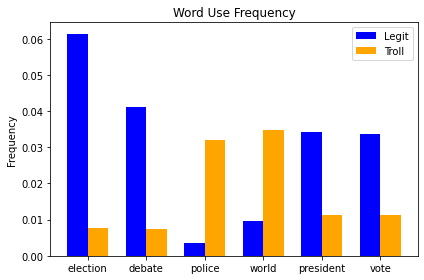

In [5]:
vectors.word_freq()
vectors.chart_word_freq(low_words=0, high_words=6)

### Random forest classifier

In [6]:
# balance count vectorized data for training
bal_matrix, bal_y_train = SMOTE().fit_resample(matrix, y_train) 

Random Forest Scores -- w/out LDA
accuracy = 0.8201848115026917
oob = 0.881172472569015
recall = 0.6499895112229914
precision = 0.22944203783923878
f_one = 0.33916208302547685


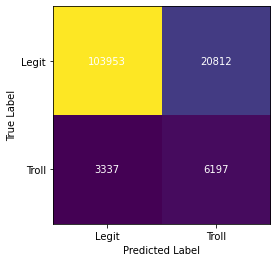

In [7]:
# random forest (without LDA) -- balanced fit, unbalanced predict
forest = RandForest(n_estimators=150, max_depth=150, max_leaf=None, 
                    max_features='log2', class_weight='balanced')
forest.fit(bal_matrix, bal_y_train)
probas, y_hat = forest.predict(matrix_test, thresh=0.542)
forest.score(y_test, y_hat)
print('Random Forest Scores -- w/out LDA')
print(f'accuracy = {forest.acc}')
print(f'oob = {forest.oob}')
print(f'recall = {forest.recall}')
print(f'precision = {forest.precision}')
print(f'f_one = {forest.f_one}')
forest.plot_confusion()

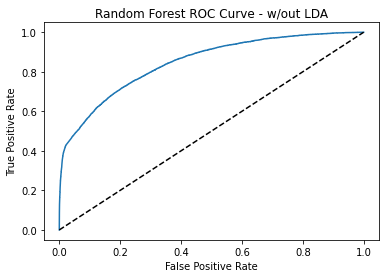

In [8]:
thresh_nolda = plot_roc_curve(matrix_test, y_test, lda=False) # wihtout LDA

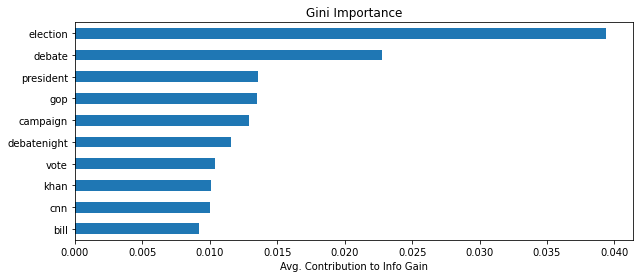

In [9]:
forest.chart_gini_import(features=10, vocab=vocab)

### LDA model

In [10]:
# # fit LDA model on training data
lda = LDA_model(topics=5)
lda.fit(matrix, y_train, vocab)
lda.phi() # to evaluate coherence score
theta = lda.theta()

# get test theta for random forest evaluation
theta_test = lda.test_theta(matrix_test)

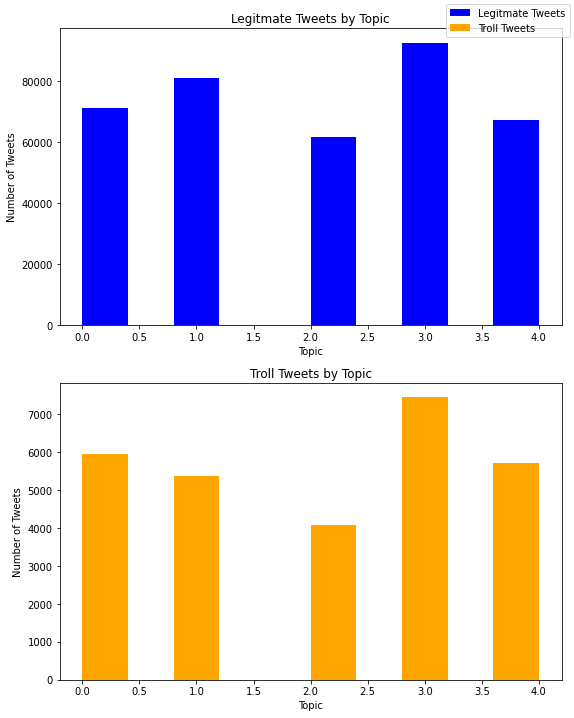

In [11]:
# get topic liklihoods by class
lda.topic_likelihood()
lda.plot_topics_by_class()

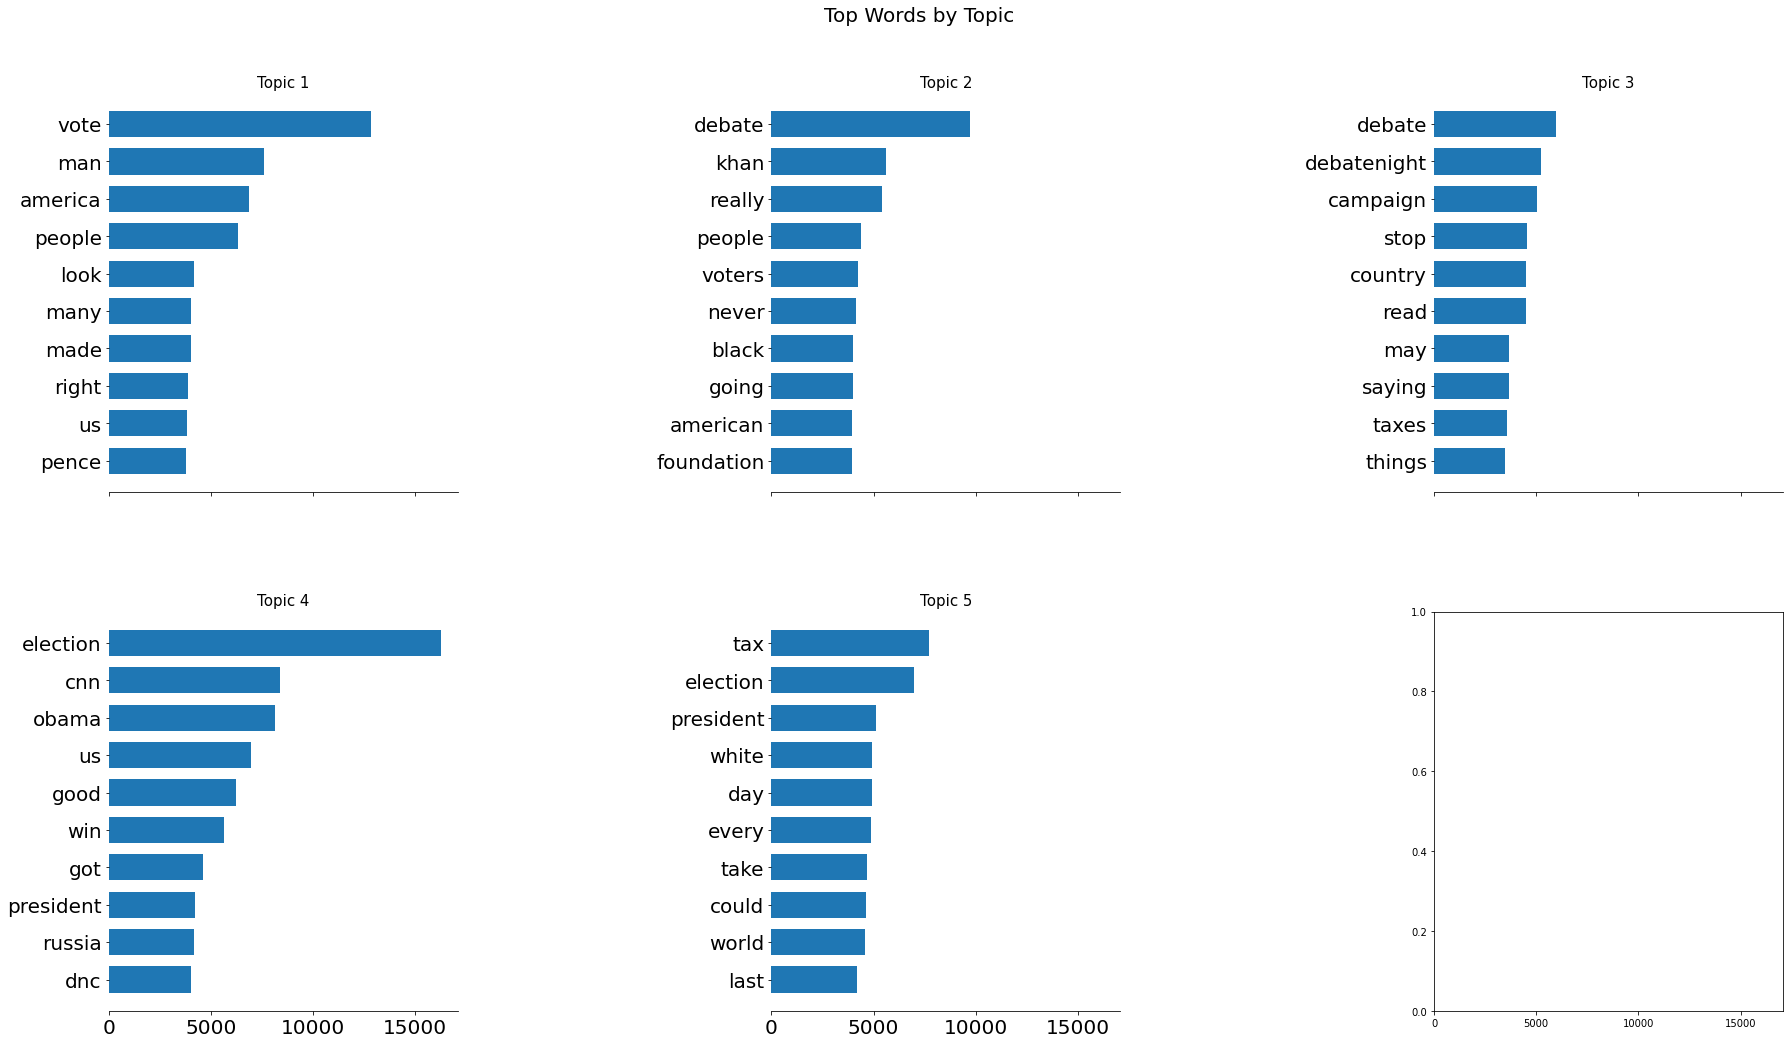

In [12]:
lda.plot_top_words()

In [13]:
lda.coherance_score()

-4.721107139129687

In [14]:
# balance count vectorized data for training
bal_theta, bal_y_train = SMOTE().fit_resample(theta, y_train) 

Random Forest Scores -- with LDA
accuracy = 0.8636922091750497
oob = 0.9103507051773563
recall = 0.36763163415145794
precision = 0.222088455202129
f_one = 0.27689998419971557


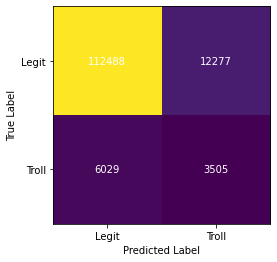

In [15]:
# random forest (with LDA)
forest = RandForest(n_estimators=150, max_depth=150, max_leaf=None, 
                    max_features=theta.shape[1], class_weight=None)
forest.fit(bal_theta, bal_y_train)
probas, y_hat = forest.predict(theta_test, thresh=.542)
forest.score(y_test, y_hat)
print('Random Forest Scores -- with LDA')
print(f'accuracy = {forest.acc}')
print(f'oob = {forest.oob}')
print(f'recall = {forest.recall}')
print(f'precision = {forest.precision}')
print(f'f_one = {forest.f_one}')
forest.plot_confusion()

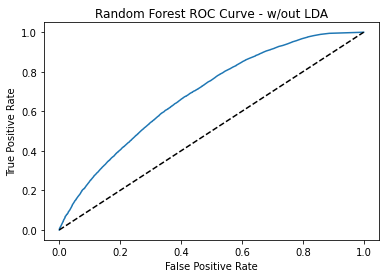

In [16]:
thresh_lda = plot_roc_curve(theta_test, y_test, lda=False) # wihtout LDA

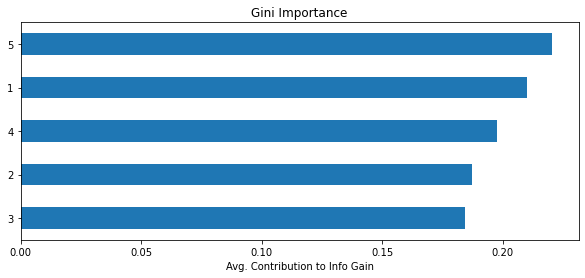

In [17]:
forest.chart_gini_import(features=-1)

### Misclassifications